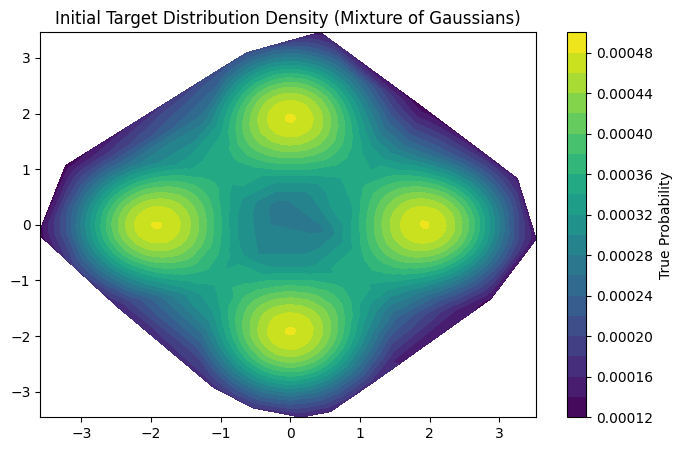

100%|██████████| 20000/20000 [01:02<00:00, 322.48it/s]


RuntimeError: Tensors must have same number of dimensions: got 1 and 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons

num_samples = 1000

# Generate samples from a standard normal distribution (p_0)
def sample_normal_distribution(num_samples):
    return np.random.normal(0, 1, (num_samples, 2))

# Generate mixture of Gaussians (p_1)
def sample_mixture_gaussians(num_samples):
    centers = np.array([[-2, 0], [2, 0], [0, 2], [0, -2]])
    num_components = centers.shape[0]
    samples_per_component = num_samples // num_components
    samples = []
    for center in centers:
        samples.append(np.random.normal(center, 0.5, (samples_per_component, 2)))
    return np.vstack(samples)

x0_train = sample_normal_distribution(num_samples)
x1_train = sample_mixture_gaussians(num_samples)
x0_train = torch.tensor(x0_train.astype(np.float32))
x1_train = torch.tensor(x1_train.astype(np.float32))

def target_distribution(x):
    centers = np.array([[-2, 0], [2, 0], [0, 2], [0, -2]])
    probs = np.sum([np.exp(-0.5 * np.sum((x - c) ** 2, axis=1)) for c in centers], axis=0)
    return probs / np.sum(probs)

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
                                              t_start + (t_end - t_start) / 2)

x_test = sample_mixture_gaussians(2500)
x_test = x_test.astype(np.float32)
true_prob = target_distribution(x_test)

plt.figure(figsize=(8, 5))
plt.tricontourf(x_test[:, 0], x_test[:, 1], true_prob, levels=20, cmap='viridis')
plt.colorbar(label='True Probability')
plt.title("Initial Target Distribution Density (Mixture of Gaussians)")
plt.show()

flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
from tqdm import tqdm
for _ in tqdm(range(20000)):
    x_1 = torch.tensor(sample_mixture_gaussians(256).astype(np.float32))
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()


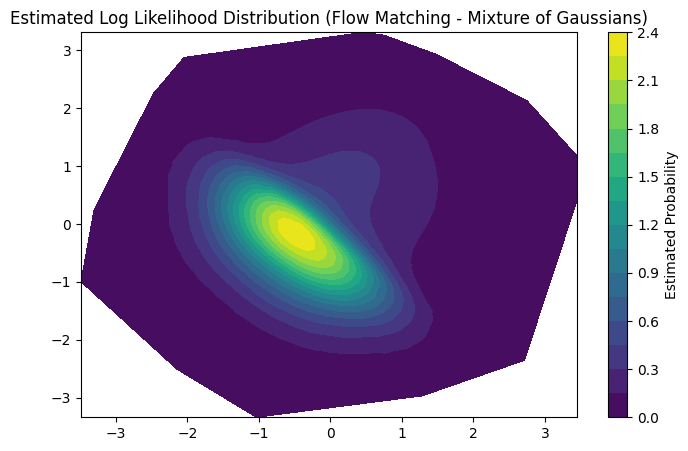

In [25]:

x_test = sample_normal_distribution(2500)
x_test = x_test.astype(np.float32)
log_p0 = -0.5 * np.sum(x_test ** 2, axis=1)  # Log probability of standard normal distribution
Z_samples = torch.randn((x_test.shape[0], 2))

t_values = torch.linspace(0, 1, 10).view(-1, 1)
log_likelihood_est = log_p0.copy()

for t in t_values:
    x_t = torch.tensor(x_test, requires_grad=True)
    t_tensor = torch.Tensor([t]).reshape(-1,1).repeat(x_t.shape[0], 1)
    u_t = flow(x_t, t_tensor)
    jacobian_trace = torch.zeros(x_test.shape[0])
    # for i in range(x_test.shape[0]):
    grad_u_t,_ = torch.autograd.functional.jvp(lambda x: flow(x, t_tensor), x_t, Z_samples)
    # jacobian_trace[i] = torch.trace(grad_u_t).detach()
    jacobian_trace = grad_u_t.sum(dim=-1)
    log_likelihood_est -= jacobian_trace.numpy() * (1.0 / len(t_values))

plt.figure(figsize=(8, 5))
plt.tricontourf(x_test[:, 0], x_test[:, 1], np.exp(log_likelihood_est), levels=20, cmap='viridis')
plt.colorbar(label='Estimated Probability')
plt.title("Estimated Log Likelihood Distribution (Flow Matching - Mixture of Gaussians)")
plt.show()

In [19]:
x,y = torch.autograd.functional.jvp(lambda x: flow(x, t_tensor), x_t, Z_samples)

In [21]:
x.shape, y.shape

(torch.Size([2500, 2]), torch.Size([2500, 2]))